[Datitos: Aprendizaje profundo](https://datitos.github.io/curso-aprendizaje-profundo/)

[T.P. N°2 - Aprendizaje Profundo 2021 by Datitos](https://www.kaggle.com/c/tp-n2-aprendizaje-profundo-2021-by-datitos-v2)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

In [3]:
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.optim import Adam

from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from IPython.display import clear_output

from callbacks import PlotLosses, Logger, ReduceLROnPlateau, TrainValLossComputer
from model import Model
from utils import try_gpu
from callbacks import CallbackSet

In [4]:
train_set = pd.read_csv('./dataset/fifa2021_training.csv')
test_set  = pd.read_csv('./dataset/fifa2021_test.csv')

In [5]:
# ProfileReport(train_set, title="Exploratory Analisys", explorative=True)to_file("report.html")

In [6]:
SKILL_FEATURES = [
    'BallControl',
    'Dribbling',
    'Marking',
    'SlideTackle',
    'StandTackle',
    'Aggression',
    'Reactions',
    'Interceptions',
    'Vision',
    'Composure',
    'Crossing', 
    'ShortPass',
    'LongPass',
    'Acceleration',
    'Stamina',
    'Strength',
    'Balance',
    'SprintSpeed',
    'Agility',
    'Jumping',
    'Heading',
    'ShotPower',
    'Finishing',
    'LongShots',
    'Curve', 
    'FKAcc',
    'Penalties',
    'Volleys',
    'GKDiving',
    'GKHandling',
    'GKKicking',
    'GKReflexes'
]

TARGET = 'Position'

In [7]:
def preprocess(df): return df[SKILL_FEATURES], pd.get_dummies(df[[TARGET]], dummy_na=True)

In [8]:
X, y = preprocess(train_set)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((9744, 32), (9744, 5), (4177, 32), (4177, 5))

In [9]:
class MyModel(Model):
    def __init__(self, X_train, y_train, n_hidden=100, lr=0.001, dropout=0.2):
        model = nn.Sequential(
            nn.Linear(X_train.shape[1], n_hidden), 
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(n_hidden, y_train.shape[1])
        ).to(device=try_gpu())

        super().__init__(
            model,
            loss = nn.MSELoss(), 
            optimizer = Adam(model.parameters(), lr=lr)
        )

In [19]:
model = MyModel(X_train, y_train).info()

Model:
 Sequential(
  (0): Linear(in_features=32, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=100, out_features=5, bias=True)
)
Params:
 [('0.weight', torch.Size([100, 32])), ('0.bias', torch.Size([100])), ('3.weight', torch.Size([5, 100])), ('3.bias', torch.Size([5]))]


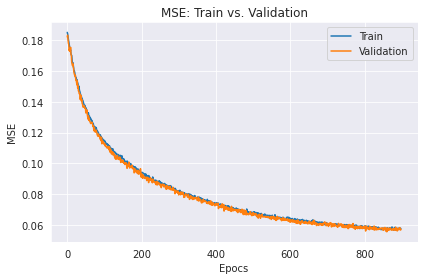

{'epoch': 1000, 'lr': 0.0001, 'train_loss': 0.05809994414448738, 'val_loss': 0.05615491047501564}


In [20]:
model.fit(
    train_set    = (X_train, y_train), 
    val_set      = (X_val, y_val),
    batch_size   = 2000,
    epochs       = 1000,
    callback_set = CallbackSet([
        TrainValLossComputer(),
        PlotLosses(warmup_count=100),
        Logger(metrics=['epoch', 'train_loss', 'val_loss', 'lr']),
        ReduceLROnPlateau(patience=40)
    ])
)